# Classification

## MNIST

### Load dataset

In [4]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

print(f"features size: {X_mnist.shape}\nlabels size:{y_mnist.shape}")

features size: (70000, 784)
labels size:(70000,)


### Visualize data

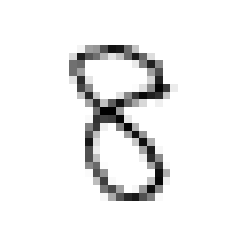

In [36]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

X, y = X_mnist, y_mnist

some_digit = X[3600]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

In [37]:
print(f"This is number: {y[3600]}")

This is number: 8


### Split data into train and test set

In [26]:
from sklearn.model_selection import train_test_split
from sklearn import random

random.seed(2910)

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,train_size=0.9 ,random_state=2910)


print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")


Train size: (63000, 784), (63000,)
Test size: (7000, 784), (7000,)


## Training a Binary Classifier

Đưa bài toán trở về đơn giản với binary classifier, xác định đâu là số 8.

In [39]:
y_train_8 = (y_train == '8')
y_test_8= (y_test == '8')


In [40]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2910)
sgd_clf.fit(X_train, y_train_8)


SGDClassifier(random_state=2910)

### Make prediction with image show above

In [41]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring accuracy using cross-validation

Sử dụng `StratifiedKfold`

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2910, shuffle=True)

for train_idx, test_idx in skfolds.split(X_train, y_train_8):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_8[train_idx]
    
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_8[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))
    

0.9330952380952381
0.9221428571428572
0.9268095238095239


Sử dụng `cross_val_score`

In [45]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring='accuracy')

array([0.93833333, 0.92771429, 0.92390476])

### Confusion Matrix

Một cách tốt hơn để có thể đánh giá hiệu năng của `classifier` là nhìn vào `confusion matrix`. Ý tưởng là đếm số lần mà class A bị classified nhầm thành class B. Ví dụ, để biết số lần bị phần biệt nhầm của 5s thành 3s thì ta sẽ nhìn vào dòng thứ 5, cột 3 của confusion matrix.

Để tạo ra confusion matrix, đầu tiên thì cần phải có list của các predictions đã tạo ra để có thể so sánh với kết quả thực tế.

Hàm `cross_val_predict` giống với `cross_val_score` nhưng chúng khác nhau ở giá trị trả về:

- `cross_val_predict` trả về giá trị predictions
- `cross_val_score` trả về accuracy

In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_8, y_train_pred)

array([[56043,   805],
       [ 3606,  2546]], dtype=int64)

Ý nghĩa của `confusion matrix` trên là:

- Mỗi dòng biểu diễn cho `actual class` và mỗi cột biểu diễn `predicted class`

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56043                |805
5s    |3606                 |2546

Ta có tất cả 63000 điểm dữ liệu:

- 56848 điểm là không phải class 5
- 6152 điểm là class 5

- Đối với 56848 điểm không phải class 5, khi đưa vào mô hình thì ta được dự đoán đúng 56043 điểm và 805 điểm bị dự đoán sai

- Đối với 6152 điểm là class 5, khi đưa vào mô hình ta được dự đoán đúng 2546 điểm và 3606 điểm bị dự đoán sai

=> Cột predicted as non-5s:  negative prediction

=> Cột predicted as 5s    :postitive prediction

Như vậy nếu như predicted class là hoàn hảo => Ta sẽ có confusion matrix dạng như sau:

#     | predicted as non-5s | predicted as 5s
------|---------------------|-----------------
non-5s|56848                |0
5s    |0                    |6152

Tức `confusion matrix` cho 100% predicted đúng sẽ là ma trận đường chéo

### Precision và Recall

#### Precision

Giá trị biểu diễn accuracy của positive prediction được gọi là `precision` của classifier

precision =$\frac{TP}{TP + FP}$

- TP là số prediction đúng của positive prediction
- FP là số prediction sai của positive prediction

#### Recall

Còn được gọi là `sensivity` hay `true positive rate`

recall = $\frac{TP}{TP + FN}$

- FN là số prediction sai của negative prediction

![](../../../imgs/precision_recall.png)

In [49]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_8, y_train_pred))

print(recall_score(y_train_8, y_train_pred))

0.759773202029245
0.4138491547464239


### F1 score

Ta dùng F1 score như là sự kết hợp của cả precision và recall để so sanh giữa các model

![](../../../imgs/f1.png)

In [50]:
from sklearn.metrics import f1_score

f1_score(y_train_8, y_train_pred)

0.5358307902767547

Tuy nhiên không phải lúc nào cũng dùng `F1 score` để đánh giá model. Trong một số trường hợp, thứ mà ta quan tâm nhiều nhất là `precision`, nhưng trong trường hợp khác ta lại quan tâm nhiều nhất là `recall`.

Ví dụ: Nếu như ta cần training một classifier để xác định video nào an toàn cho trẻ em, hiển nhiên là ta sẽ muốn một classifier mà có khả năng nhận diện ra video xấu lớn => TP lớn, FP nhỏ => precision lớn và recall nhỏ

Và hiển nhiên là ta không thể nào có lợi được cả về recall và precision, ta chỉ có thể đánh đổi một bên để cho bên kia được tố nhất. Vậy cho nên ta có định nghĩa `precision/recall tradeoff`


### Precision/Recall Tradeoff

Để hiểu định nghĩa ta sẽ xem `SGDClassifier` thực hiện classification decisions thế nào.

## Multiclass Classification

## Error Analysis

## Multilabel Classification

## Multiouput Classification